In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import kerastuner as kt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# 2. Функція для побудови моделі з використанням Keras Tuner
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    # Підбір кількості нейронів у першому шарі
    hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=64)
    model.add(layers.Dense(units=hp_units_1, activation='relu'))

    # Dropout для регуляризації
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Підбір кількості нейронів у другому шарі
    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(units=hp_units_2, activation='relu'))

    # Вихідний шар
    model.add(layers.Dense(10, activation='softmax'))

    # Підбір оптимізатора
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    # Компіляція моделі
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# 3. Ініціалізація тюнера з RandomSearch для підбору гіперпараметрів
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='fashion_mnist_tuning')

In [ ]:
# 4. Використання ранньої зупинки для запобігання перенавчанню
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Завантаження датасету Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Нормалізація даних
train_images = train_images / 255.0
test_images = test_images / 255.0


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 5. Запуск пошуку гіперпараметрів
tuner.search(train_images, train_labels, epochs=10, validation_split=0.2, callbacks=[early_stopping])


Trial 4 Complete [00h 02m 41s]
val_accuracy: 0.8877500295639038

Best val_accuracy So Far: 0.890999972820282
Total elapsed time: 00h 08m 24s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
384               |512               |units_1
0.4               |0.2               |dropout_1
64                |128               |units_2
adam              |adam              |optimizer

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7329 - loss: 0.7351 - val_accuracy: 0.8523 - val_loss: 0.4092
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8398 - loss: 0.4368 - val_accuracy: 0.8552 - val_loss: 0.3833
Epoch 3/10
 923/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8506 - loss: 0.3992

KeyboardInterrupt: 

In [ ]:
# 6. Отримання найкращої моделі
best_model = tuner.get_best_models(num_models=1)[0]

# 7. Оцінка моделі
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 468,874 (1.79 MB)

 Trainable params: 468,874 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8989 - loss: 0.2654 - val_accuracy: 0.8916 - val_loss: 0.3030
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9058 - loss: 0.2480 - val_accuracy: 0.8897 - val_loss: 0.3124
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9085 - loss: 0.2443 - val_accuracy: 0.8907 - val_loss: 0.3271
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9092 - loss: 0.2398 - val_accuracy: 0.8880 - val_loss: 0.3245


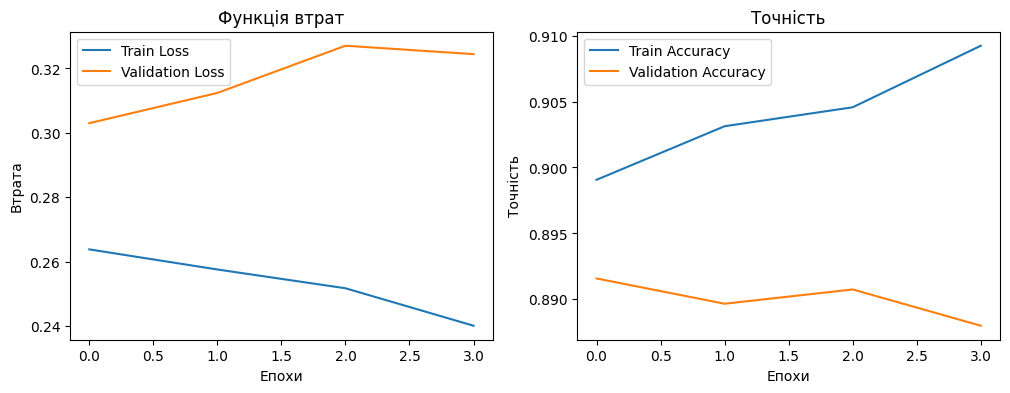

In [ ]:
# 8. Навчання та оцінка моделі
history = best_model.fit(train_images, train_labels, epochs=10, validation_split=0.2,
                         callbacks=[early_stopping])

# Побудова графіків функції втрат і точності
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функція втрат')
plt.xlabel('Епохи')
plt.ylabel('Втрата')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8840 - loss: 0.3249
Тестова точність: 0.8824
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1000
           1       0.98      0.97      0.98      1000
           2       0.81      0.77      0.79      1000
           3       0.86      0.90      0.88      1000
           4       0.77      0.85      0.81      1000
           5       0.99      0.95      0.97      1000
           6       0.76      0.60      0.67      1000
           7       0.92      0.98      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



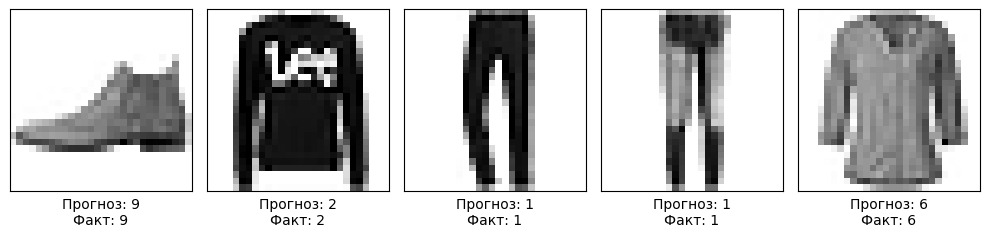

In [ ]:
# Оцінка на тестових даних
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f'Тестова точність: {test_acc:.4f}')

# Класифікаційний звіт
predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, predicted_labels))

# Виведення результатів прогнозування
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"Прогноз: {predicted_labels[i]}\nФакт: {test_labels[i]}")
plt.tight_layout()
plt.show()

У другому завданні я використав Keras Tuner для підбору гіперпараметрів моделі, аналогічної до першої. Пошук допоміг знайти оптимальну кількість нейронів у шарах, значення Dropout та вибрати найкращий оптимізатор. Після підбору модель показала покращену точність на тестових даних, а також стабільніші графіки функції втрат і точності.


